In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# URL, HTML, brackets, digits
import re
from bs4 import BeautifulSoup
# Contractions
# !pip install contractions
import contractions

In [4]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/chinmay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chinmay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chinmay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chinmay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [5]:
# Tokenization, punctuations and stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords, wordnet

In [6]:
# Lemmatization
from nltk.stem import WordNetLemmatizer

# Sentiment Analysis
from textblob import TextBlob

# Frequency Analysis
from nltk.probability import FreqDist
from wordcloud import WordCloud

In [7]:
# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Training
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score

In [8]:
df = pd.read_csv("../datasets/train_df.csv")
test_df = pd.read_csv("../datasets/test_df.csv")

df

,qid,question_text,target
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0
...,...,...,...
999995,4bd96088d0b5f0f2c4f4,How is CSE at VIT Chennai?,0
999996,e80edbfc086f7125940f,"How can we prevent a holocaust by robots, AI, ...",0
999997,1506dfad6bd340782a1f,How can I help a student remember key steps an...,0
999998,b56c60fd407f2f85553c,What is the difference between lace closure & ...,0


## Preprocessing


In [9]:
df.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [10]:
(df=='?').sum()

qid              0
question_text    0
target           0
dtype: int64

In [11]:
(df==' ').sum()

qid              0
question_text    0
target           0
dtype: int64

In [12]:
df.duplicated().sum()


0

In [13]:
df[df['target']==1]['target'].value_counts()


1    61870
Name: target, dtype: int64

In [14]:
df['target'].value_counts()


0    938130
1     61870
Name: target, dtype: int64

Text(0.5, 1.0, 'Target value count')

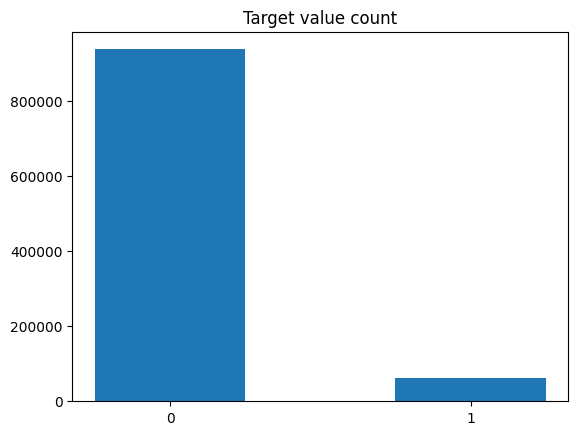

In [15]:
plt.bar(['0','1'], df['target'].value_counts(), width=0.5)
plt.title('Target value count')

In [16]:
def remove_url(data_column):
  return data_column.apply(lambda sentence: re.sub(r'https://','', sentence))
def remove_html(data_column):
  return data_column.apply(lambda sentence: BeautifulSoup(sentence, 'html.parser').get_text())
def remove_bracket(data_column):
  temp = data_column.apply(lambda sentence: re.sub('\(.*?\)','', sentence))
  return temp.apply(lambda sentence: re.sub('\[.*?\]','', sentence))
def remove_digit(data_column):
  return data_column.apply(lambda sentence: re.sub('[0-9]','', sentence))
def remove_underscore(data_column):
  return data_column.apply(lambda sentence: sentence.replace("_",""))

In [17]:
def expand_contractions(data_column):
  contractions_expanded = data_column.apply(lambda sentence: [contractions.fix(word) for word in sentence.split()])
  return [' '.join(map(str, word)) for word in contractions_expanded]

In [18]:
def tokenize(data_column):
  return data_column.apply(word_tokenize)
def lower_case(data_column):
  return data_column.apply(lambda tokens: [word.lower() for word in tokens])
def remove_punctuation(data_column):
  return data_column.apply(lambda tokens: [re.sub(r'[^\w\s]', '', word) for word in tokens])
  # punctuations = string.punctuation
  # return data_column.apply(lambda tokens: [word for word in tokens if word not in punctuations])
def remove_stopwords(data_column):
  stop_words = set(stopwords.words('english'))
  return data_column.apply(lambda tokens: [word for word in tokens if word not in stop_words and word])

In [19]:
def pos_tags(data_column):
  return data_column.apply(nltk.tag.pos_tag)

In [20]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:

def to_wordnet(data_column):
  return data_column.apply(lambda words: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in words])
def word_lemmatizer(data_column):
  wnl = WordNetLemmatizer()
  return data_column.apply(lambda words: [wnl.lemmatize(word, tag) for word, tag in words])

In [22]:
def pre_processing(data, df):
  data = remove_url(data)
  data = remove_html(data)
  data = remove_bracket(data)
  data = remove_digit(data)
  data = remove_underscore(data)

  df['sentences'] = expand_contractions(data)
  data = tokenize(df['sentences'])
  df.drop('sentences', axis='columns', inplace=True)
  data = lower_case(data)
  data = remove_punctuation(data)
  data = remove_stopwords(data)

  data = pos_tags(data)
  data = to_wordnet(data)
  return word_lemmatizer(data)

In [23]:
df.shape, test_df.shape

((1000000, 3), (306122, 2))

In [24]:
full_df = pd.concat([df, test_df])

In [25]:
full_df.shape

(1306122, 3)

In [26]:
full_df['processed_data'] = pre_processing(full_df['question_text'], full_df)

/home/chinmay/.local/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [ ]:
full_df.head()

# Sentiment analysis

In [ ]:
df['processed_data'] = full_df[0:df.shape[0]]['processed_data']

NameError: name 'full_df' is not defined

In [ ]:
df.head()

In [ ]:
def sentiment_analysis(data_column):
  df['lemmatized_join'] = [' '.join(map(str,words)) for words in data_column]
  lemmatized_join = df['lemmatized_join']
  df.drop('lemmatized_join', axis = 1, inplace=True)
  return lemmatized_join.apply(lambda sentence: TextBlob(sentence).sentiment.polarity)

In [ ]:
df['sentiment'] = sentiment_analysis(df['processed_data'])

In [ ]:
df.head()

In [ ]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['sentiment'], bins=10)
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
len(df[df['sentiment']>=0])